# Understand the dataset
The provided dataset comprises a training dataset stored in an Excel file named "Training dataset.xlsx" and a test dataset stored in another Excel file named "Test dataset.xlsx". The training dataset is loaded into a Pandas DataFrame named train_df, while the test dataset is loaded into another DataFrame named test_df. The training dataset consists of features and a target variable named "Sourcing Cost". The data types of each column are checked, and columns with missing values are identified and handled through imputation. Categorical variables are one-hot encoded, and numerical features are standardized using StandardScaler. Feature selection is performed using SelectKBest and f_regression, and outliers are detected and removed based on z-scores. Exploratory Data Analysis (EDA) is conducted to visualize the distribution of the target variable and explore relationships between variables using scatter plots, box plots, and bar plots. Finally, three regression models—Linear Regression, Random Forest Regression, and Gradient Boosting Regression—are trained and evaluated using Mean Squared Error (MSE).

# Importing Dataset

In [78]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [79]:
# Importing Dataset
train_df = pd.read_excel("Training dataset.xlsx")
train_df

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,2021-05-01,10.158
1,NTM2,X1,A9,DIRECT,Large,Powder,2020-10-01,134.281
2,NTM3,X2,A20,DIRECT,Large,Powder,2020-12-01,12.456
3,NTM3,X1,A18,WHOLESALE,Small,Powder,2021-02-01,107.220
4,NTM2,X1,A28,DIRECT,Large,Liquid,2020-11-01,197.763
...,...,...,...,...,...,...,...,...
550171,NTM2,X1,A5,DIRECT,Large,Powder,2020-07-01,136.469
550172,NTM3,X1,A14,DIRECT,Large,Liquid,2020-10-01,72.559
550173,NTM2,X1,A5,DIRECT,Small,Powder,2021-03-01,147.639
550174,NTM2,X1,A7,DIRECT,Small,Powder,2021-02-01,150.044


In [111]:
# Display the first few rows of the training dataset
print("Training Dataset:")
print(train_df.head())

Training Dataset:
  ProductType Manufacturer Area Code Sourcing Channel Product Size  \
0        NTM3           X1       A28        WHOLESALE        Large   
1        NTM2           X1        A9           DIRECT        Large   
2        NTM3           X2       A20           DIRECT        Large   
3        NTM3           X1       A18        WHOLESALE        Small   
4        NTM2           X1       A28           DIRECT        Large   

  Product Type Month of Sourcing  Sourcing Cost  
0       Powder        2021-05-01         10.158  
1       Powder        2020-10-01        134.281  
2       Powder        2020-12-01         12.456  
3       Powder        2021-02-01        107.220  
4       Liquid        2020-11-01        197.763  


In [82]:
# Check the data types of each column
print("Data Types of Each Column:")
print(train_df.dtypes)

Data Types of Each Column:
ProductType                  object
Manufacturer                 object
Area Code                    object
Sourcing Channel             object
Product Size                 object
Product Type                 object
Month of Sourcing    datetime64[ns]
Sourcing Cost               float64
dtype: object


# Data Preprocessing

In [83]:
# Identify columns with missing values
cols_with_missing = train_df.columns[train_df.isnull().any()]
missing_counts = train_df[cols_with_missing].isnull().sum()
print("Columns with missing values and their counts:")
print(missing_counts)

Columns with missing values and their counts:
Series([], dtype: float64)


In [84]:
# For numerical columns, replace missing values with the mean of the column
for col in train_df.select_dtypes(include='number').columns:
    train_df[col].fillna(train_df[col].mean(), inplace=True)

# For categorical columns, replace missing values with the most frequent value of the column
for col in train_df.select_dtypes(exclude='number').columns:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

In [85]:
# One-hot encoding for categorical variables
train_df_encoded = pd.get_dummies(train_df, columns=train_df.select_dtypes(exclude='number').columns)

In [86]:
# Define a pipeline for preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [87]:
from sklearn.preprocessing import StandardScaler

# Scale numerical features using StandardScaler
scaler = StandardScaler()
numerical_cols = train_df_encoded.select_dtypes(include='number').columns
train_df_encoded[numerical_cols] = scaler.fit_transform(train_df_encoded[numerical_cols])

In [88]:
from sklearn.feature_selection import SelectKBest, f_regression

# Select top K features using SelectKBest and f_regression
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(train_df_encoded.drop('Sourcing Cost', axis=1), train_df_encoded['Sourcing Cost'])
selected_features = train_df_encoded.drop('Sourcing Cost', axis=1).columns[selector.get_support()]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['ProductType_NTM2', 'ProductType_NTM3', 'Manufacturer_X1',
       'Manufacturer_X2', 'Area Code_A12', 'Area Code_A14', 'Area Code_A40',
       'Area Code_A42', 'Area Code_A44', 'Area Code_A45'],
      dtype='object')


# Removing Outliers

In [89]:
from scipy import stats

# Calculate z-scores for each numerical column in the processed feature matrix (X_selected)
z_scores = stats.zscore(X_selected)

# Define a threshold for identifying outliers
threshold = 3

# Find the indices of outliers
outlier_indices = (np.abs(z_scores) >= threshold).any(axis=1)

# Remove outliers from the processed training dataset
X_train_no_outliers = X_selected[~outlier_indices]  # Use to select non-outliers
y_train_no_outliers = train_df_encoded['Sourcing Cost'][~outlier_indices]

# Exploratory Data Analysis

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

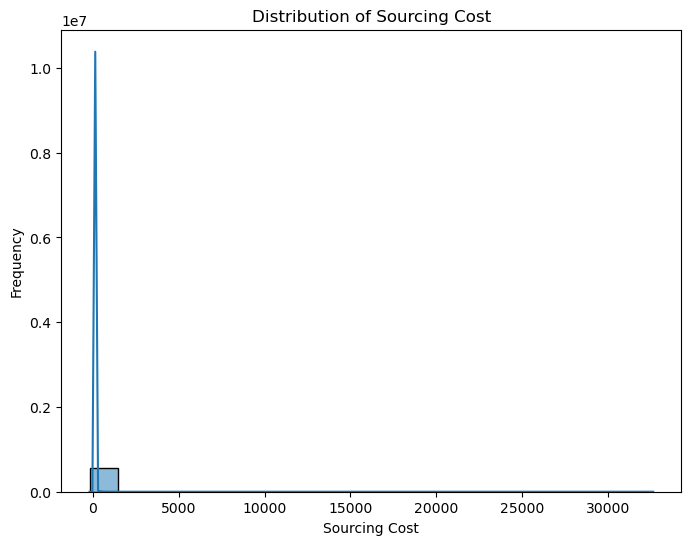

In [91]:
# Plot histogram of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(train_df['Sourcing Cost'], bins=20, kde=True)
plt.title('Distribution of Sourcing Cost')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')
plt.show()

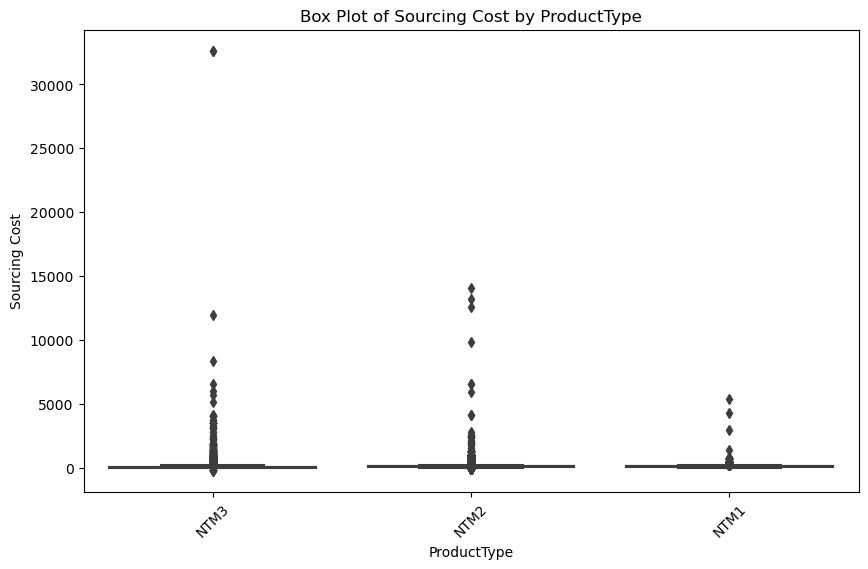

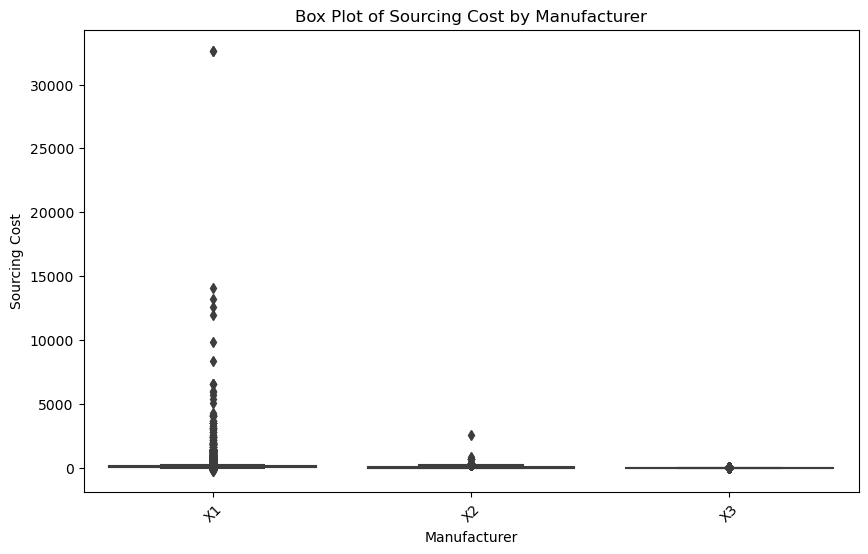

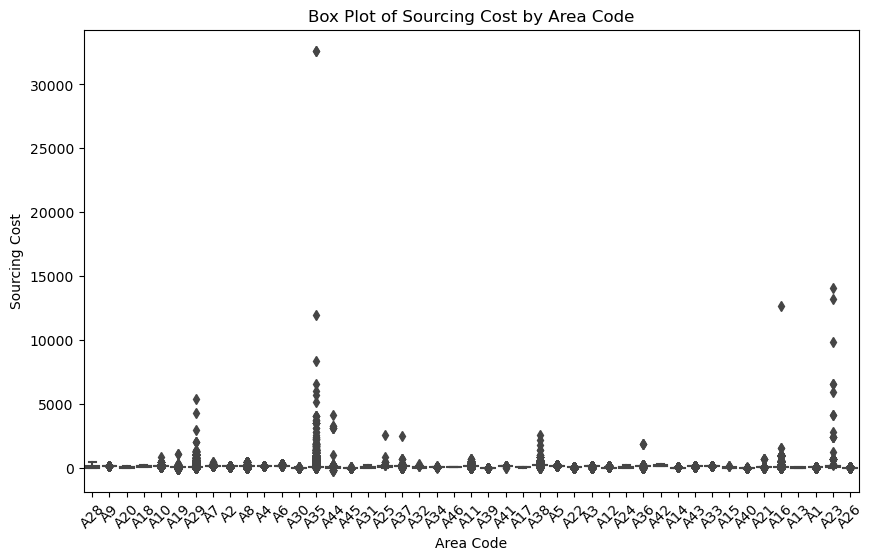

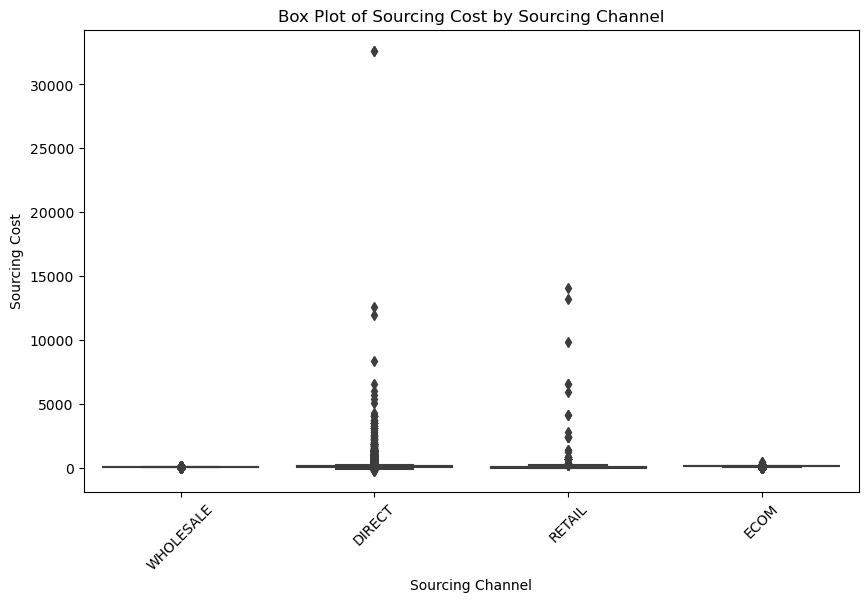

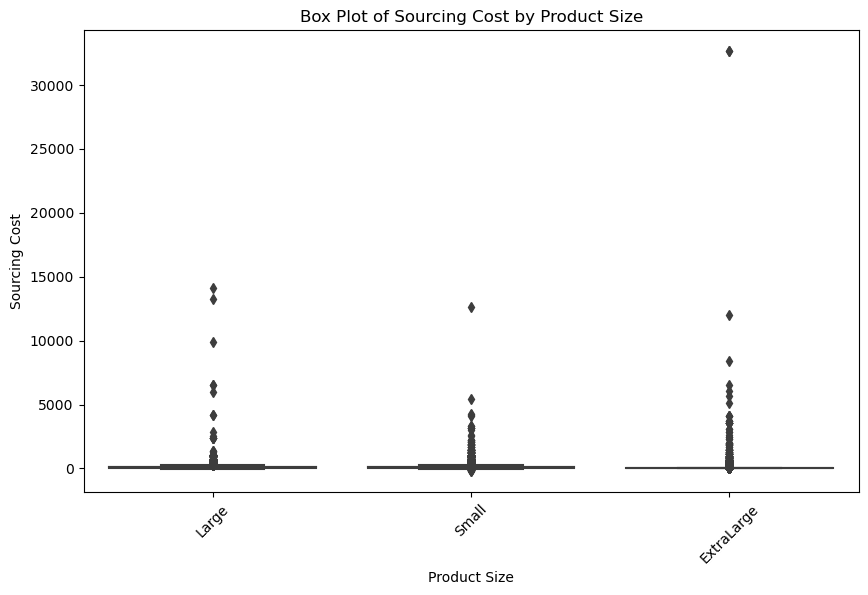

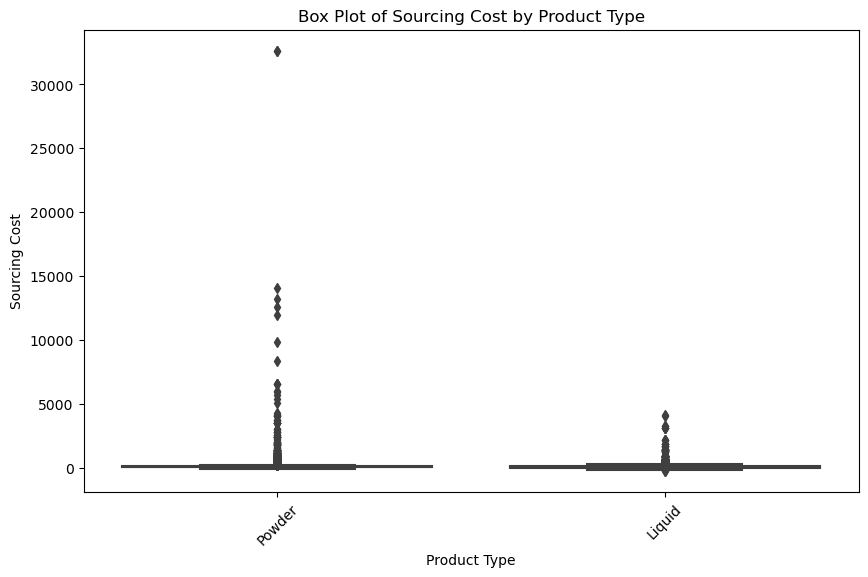

In [92]:
# Plot box plots for categorical variables
categorical_cols = train_df.select_dtypes(include='object').columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='Sourcing Cost', data=train_df)
    plt.title(f'Box Plot of Sourcing Cost by {col}')
    plt.xlabel(col)
    plt.ylabel('Sourcing Cost')
    plt.xticks(rotation=45)
    plt.show()

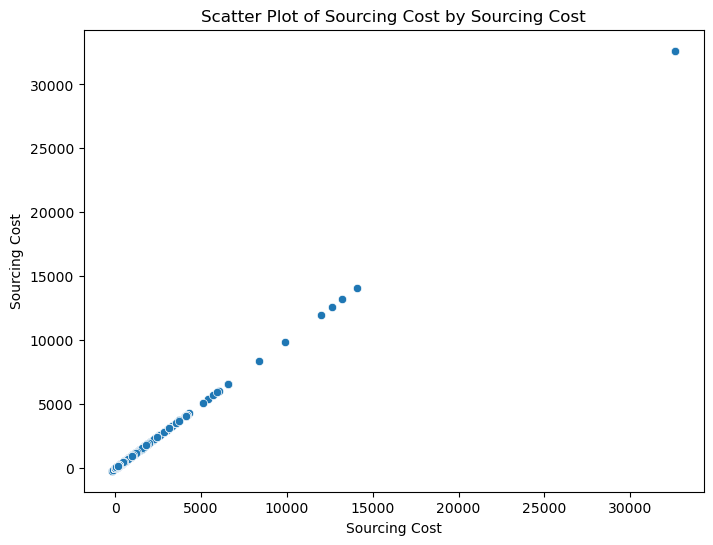

In [93]:
# Plot scatter plots for numerical variables
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='Sourcing Cost', data=train_df)
    plt.title(f'Scatter Plot of Sourcing Cost by {col}')
    plt.xlabel(col)
    plt.ylabel('Sourcing Cost')
    plt.show()

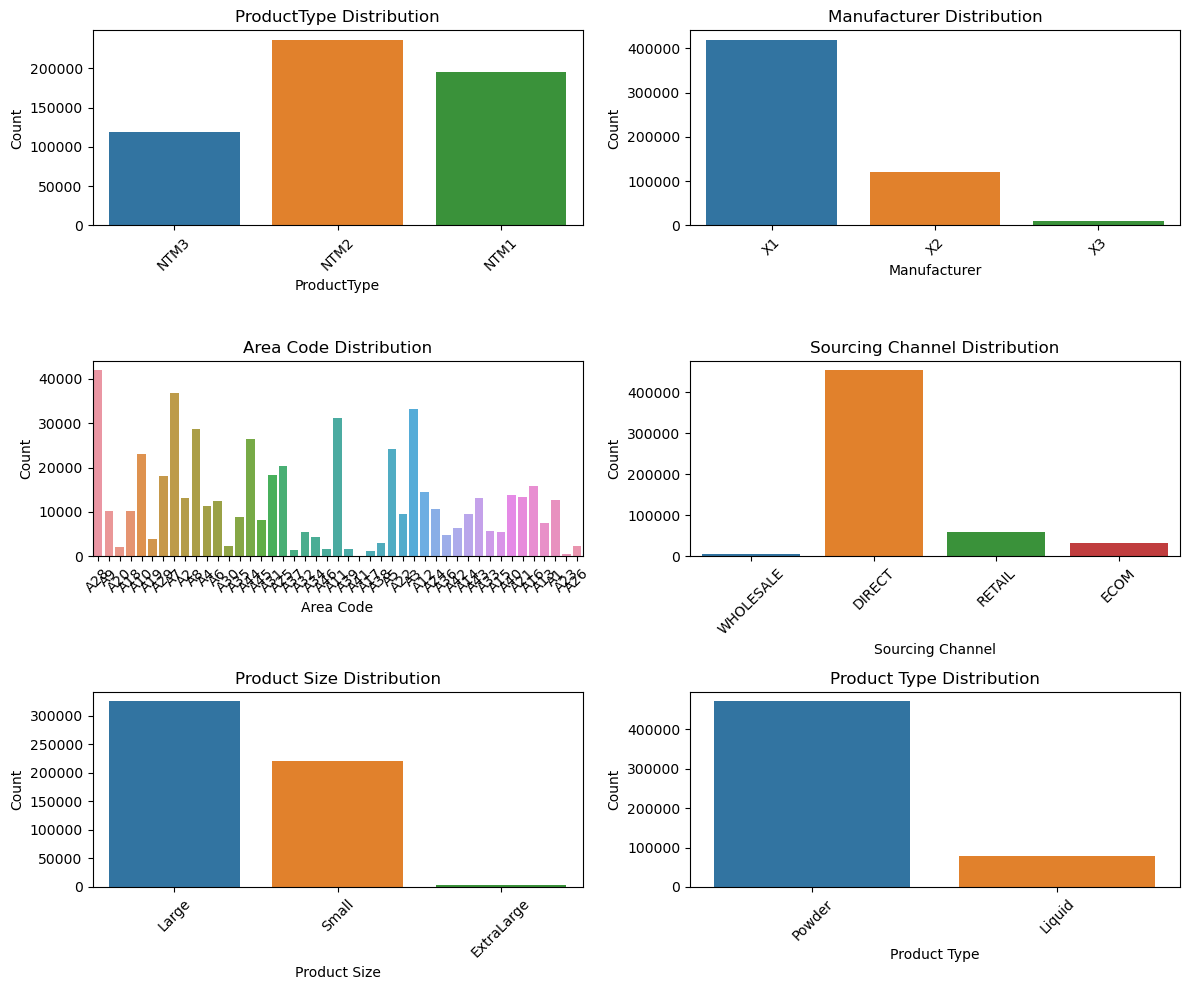

In [94]:
# Plot bar plots for categorical variables
categorical_cols = train_df.select_dtypes(include='object').columns

plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=col, data=train_df)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Forecasting

## Comparing different approaches
Comparing the models, Random Forest Regression showed the lowest Mean Squared Error (MSE) at 0.2812, indicating superior predictive performance. Gradient Boosting Regression followed with an MSE of 0.3027, slightly higher but still competitive. Linear Regression had the highest MSE at 0.3035, suggesting limitations in capturing complex data patterns. Therefore, Random Forest Regression is the preferred model due to its lower MSE, showcasing its ability to handle nonlinear relationships effectively.

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [96]:
# Separate features (X) and target variable (y)
X = train_df_encoded.drop('Sourcing Cost', axis=1)
y = train_df_encoded['Sourcing Cost']

In [97]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Initialize and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test)

# Evaluate the model
lr_mse = mean_squared_error(y_test, lr_predictions)
print("Linear Regression Mean Squared Error:", lr_mse)

Linear Regression Mean Squared Error: 0.3034623594426642


In [99]:
# Initialize and train the random forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
print("Random Forest Mean Squared Error:", rf_mse)

Random Forest Mean Squared Error: 0.2811514085005979


In [100]:
# Initialize Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=42)

# Train the model
gb_regressor.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_regressor.predict(X_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
print("Gradient Boosting Mean Squared Error:", mse_gb)

Gradient Boosting Mean Squared Error: 0.30268313393669427


In [101]:
test_df = pd.read_excel("Test dataset.xlsx")
test_df

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM1,X1,A1,DIRECT,Small,Powder,2021-06-21,103.68
1,NTM1,X1,A10,DIRECT,Large,Powder,2021-06-21,155.75
2,NTM1,X1,A10,ECOM,Large,Powder,2021-06-21,143.02
3,NTM1,X1,A11,DIRECT,Large,Powder,2021-06-21,139.39
4,NTM1,X1,A2,DIRECT,Large,Powder,2021-06-21,169.42
...,...,...,...,...,...,...,...,...
91,NTM3,X1,A44,DIRECT,Small,Liquid,2021-06-21,89.57
92,NTM3,X1,A8,DIRECT,Large,Powder,2021-06-21,114.57
93,NTM3,X1,A8,DIRECT,Small,Powder,2021-06-21,111.26
94,NTM3,X2,A20,DIRECT,Large,Powder,2021-06-21,32.32


In [102]:
# Identify columns with missing values
cols_with_missing = test_df.columns[test_df.isnull().any()]
missing_counts = test_df[cols_with_missing].isnull().sum()
print("Columns with missing values and their counts:")
print(missing_counts)

Columns with missing values and their counts:
Series([], dtype: float64)


In [103]:
# For numerical columns, replace missing values with the mean of the column
for col in test_df.select_dtypes(include='number').columns:
    test_df[col].fillna(test_df[col].mean(), inplace=True)

# For categorical columns, replace missing values with the most frequent value of the column
for col in test_df.select_dtypes(exclude='number').columns:
    test_df[col].fillna(test_df[col].mode()[0], inplace=True)

In [104]:
# One-hot encoding for categorical variables
test_df_encoded = pd.get_dummies(test_df, columns=test_df.select_dtypes(exclude='number').columns)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [105]:
from sklearn.preprocessing import StandardScaler

# Scale numerical features using StandardScaler
scaler = StandardScaler()
numerical_cols = test_df_encoded.select_dtypes(include='number').columns
test_df_encoded[numerical_cols] = scaler.fit_transform(test_df_encoded[numerical_cols])

In [106]:
from sklearn.feature_selection import SelectKBest, f_regression

# Select top K features using SelectKBest and f_regression
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(test_df_encoded.drop('Sourcing Cost', axis=1), test_df_encoded['Sourcing Cost'])
selected_features = test_df_encoded.drop('Sourcing Cost', axis=1).columns[selector.get_support()]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['ProductType_NTM3', 'Manufacturer_X1', 'Manufacturer_X2',
       'Area Code_A2', 'Area Code_A31', 'Area Code_A37', 'Area Code_A42',
       'Area Code_A45', 'Area Code_A7', 'Sourcing Channel_ECOM'],
      dtype='object')


## Final Approach
The final approach involved using the trained Random Forest Regression model to make predictions on new data. Categorical variables in the test dataset were encoded using one-hot encoding, and the columns of the encoded test data were aligned with those of the training data to ensure consistency. Predictions were then generated using the Random Forest model on the aligned test data. Evaluation of the model's performance on the new data was conducted using various regression metrics, including R-squared (R2 Score), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Median Absolute Error (MedAE). This approach was chosen to assess the model's ability to generalize to unseen data and provide insights into its predictive accuracy and reliability in real-world scenarios.

In [107]:
# Encode categorical variables using one-hot encoding
test_df_encoded = pd.get_dummies(test_df)

# Align the columns of the encoded test data with the columns of the training data
test_df_aligned = test_df_encoded.reindex(columns=X_train.columns, fill_value=0)

# Make predictions using the trained Random Forest model
rf_predictions_new = rf_model.predict(test_df_aligned)

# Print the predictions
print("Random Forest Predictions on New Data:", rf_predictions_new)

Random Forest Predictions on New Data: [-0.00686343  0.49561391  0.38655768  0.35375963  0.55074056  0.61959757
 -0.57223777 -0.50098771  0.39170529  0.39208607  0.39160783  0.23453594
 -0.13235743  0.32459576  0.33299378  0.45817588  0.54370065  0.32230565
  0.32618892  0.39352146  0.40875024  0.36432617  0.37287404 -0.75382368
 -0.28711378 -0.64669759 -0.86140694 -0.74177481 -0.80528506  0.82616517
  0.72119923  0.57547314 -0.76960929 -0.79081187 -0.39100289  0.38988166
  0.4059485   0.34848104  0.34182788 -0.10524265 -0.46588329  0.02232201
  0.61013506  0.61448513 -0.21907553 -0.66902835  0.84917988  0.84071389
 -0.09268045 -0.50097496 -0.50097467  0.38743813 -0.13611349 -0.43466287
  0.70807785  0.54437399  0.67654938  0.94625562  0.74433669  0.32152335
  0.305391    0.39267597  0.38838887  0.32315563  0.32455693  0.33391814
  0.34116464  0.32226078  0.3258999   0.42984766  0.38322736  0.0549572
 -0.38340829 -0.48022255 -0.91409004 -0.51899215 -0.79222207  0.11701397
  0.01099147 

In [110]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error

# Calculate R-squared (R2 Score)
r2 = r2_score(actual_values, rf_predictions_new)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(actual_values, rf_predictions_new, squared=False)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(actual_values, rf_predictions_new)

# Calculate Median Absolute Error (MedAE)
medae = median_absolute_error(actual_values, rf_predictions_new)

print("R-squared (R2 Score):", r2)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Median Absolute Error (MedAE):", medae)

R-squared (R2 Score): -4.140276157775304
Root Mean Squared Error (RMSE): 118.09044750345448
Mean Absolute Error (MAE): 106.17966985018698
Mean Absolute Percentage Error (MAPE): 1.0047783915604205
Median Absolute Error (MedAE): 116.9884334620092


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
